# 2D Bicopter (Quadcopter)

We consider the self-righting quadrotor problem, see also: [Stanford AA203 HW](https://stanfordasl.github.io/aa203_sp2021/pdfs/homework/AA203_HW3.pdf)

We only consider vertical obstacles (floor and ceiling) and hence consider the reduced state for obstacle avoidance, whereas we consider the extended state for reaching a target


Extended state: $\mathbf{x} = [x, v_x, y, v_y, \phi, \omega]^T$
Reduced state: $\mathbf{x} = [y, v_y, \phi, \omega]^T$

Extended Dynamics:
$$\dot{x} = \begin{bmatrix}x_2 \\ \frac{ - C_D^v x_2}{m} \\ x_4 \\ \frac{ - C_D^v x_4}{m} - g\\ x_6 \\ \frac{- C_D^\phi x_6}{I{yy}}\end{bmatrix} + \begin{bmatrix}0 & 0 \\ \frac{-\sin(x_5)}{m} & \frac{-\sin(x_5)}{m} \\0 & 0 \\ \frac{\cos(x_5)}{m} & \frac{\cos(x_5)}{m} \\ 0 & 0 \\ -\frac{l}{I_{yy}} & \frac{l}{I_{yy}}\end{bmatrix}\underbrace{\begin{bmatrix}T_1 \\ T_2\end{bmatrix}}_{u}$$


Reduced Dynamics: 
$$\dot{x} = \begin{bmatrix}x_2 \\ \frac{ - C_D^v x_2}{m} - g \\ x_4 \\ \frac{- C_D^\phi x_4}{I{yy}}\end{bmatrix} + \begin{bmatrix}0 & 0 \\ \frac{\cos(x_3)}{m} & \frac{\cos(x_3)}{m} \\ 0 & 0 \\ -\frac{l}{I_{yy}} & \frac{l}{I_{yy}}\end{bmatrix}\underbrace{\begin{bmatrix}T_1 \\ T_2\end{bmatrix}}_{u}

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.version

'3.8.13 (default, Mar 28 2022, 06:13:39) \n[Clang 12.0.0 ]'

In [3]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import seaborn as sns

import matplotlib
import pickle as pkl
import pandas as pd

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
import hj_reachability as hj
from cbf_opt import ControlAffineDynamics, ControlAffineCBF, ControlAffineASIF, utils
from experiment_wrapper import RolloutTrajectory, StateSpaceExperiment

from refine_cbfs import HJControlAffineDynamics, TabularControlAffineCBF

## Setup Problem (dynamics, environment and CBF)

### Parameter values

Dynamics properties

In [5]:
Cd_v = 0.25  # Drag coefficient
g = 9.81  # kg m / s^2
Cd_phi = 0.02255  # Drag coefficient
mass = 2.5  # kg
length = 1.0  # m
Iyy = 1.0  # kg m^2
dt = 0.01  # s

umax = 0.75 * mass * g * np.ones(2)
umin = np.zeros_like(umax)

### Dynamics

In [6]:
class QuadVerticalDynamics(ControlAffineDynamics):
    STATES = ['Y', 'YDOT', 'PHI', 'PHIDOT']
    CONTROLS = ['T1', 'T2']
    PERIODIC_DIMS = [2]
    
    def __init__(self, params, **kwargs):
        self.Cd_v = params["Cd_v"]
        self.g = params["g"]
        self.Cd_phi = params["Cd_phi"]
        self.mass = params["mass"]
        self.length = params["length"]
        self.Iyy = params["Iyy"]
        super().__init__(params, **kwargs)

    def open_loop_dynamics(self, state: np.ndarray, time: float = 0) -> np.ndarray:
        f = np.zeros_like(state)
        f[..., 0] = state[..., 1]
        f[..., 1] = -self.Cd_v / self.mass * state[..., 1] - self.g
        f[..., 2] = state[..., 3]
        f[..., 3] = -self.Cd_phi / self.Iyy * state[..., 3]
        return f

    def control_matrix(self, state: np.ndarray, time: float = 0) -> np.ndarray:
        B = np.repeat(np.zeros_like(state)[..., None], self.control_dims, axis=-1)
        B[..., 1, :] = np.cos(state[..., 2]) / self.mass
        B[..., 3, 0] = - self.length / self.Iyy
        B[..., 3, 1] = self.length / self.Iyy
        return B
    
    def disturbance_jacobian(self, state: np.ndarray, time: float = 0) -> np.ndarray:
        return np.repeat(np.zeros_like(state)[..., None], 1, axis=-1)

    def state_jacobian(self, state: np.ndarray, control: np.ndarray, time: float = 0) -> np.ndarray:
        J = np.repeat(np.zeros_like(state)[..., None], state.shape[-1], axis=-1)
        J[..., 0, 1] = 1.0
        J[..., 1, 1] = -self.Cd_v / self.mass
        J[..., 1, 2] = -(control[..., 0] + control[..., 1]) * np.sin(state[..., 2]) / self.mass
        J[..., 2, 3] = 1.0
        J[..., 3, 3] = -self.Cd_phi / self.Iyy
        return J

class QuadVerticalDynamicsJNP(QuadVerticalDynamics):

    def open_loop_dynamics(self, state, time=0.0):
        return jnp.array([
            state[1], 
            -state[1] * self.Cd_v / self.mass - self.g, 
            state[3], 
            -state[3] * self.Cd_phi / self.Iyy
            ])
    
    def control_matrix(self, state, time=0.0):
        return jnp.array([
            [0, 0], 
            [jnp.cos(state[2]) / self.mass, jnp.cos(state[2]) / self.mass], 
            [0, 0], 
            [-self.length / self.Iyy, self.length / self.Iyy]
            ])

    def disturbance_jacobian(self, state: np.ndarray, time: float = 0) -> np.ndarray:
        return jnp.expand_dims(jnp.zeros(4), axis=-1)
    
    def state_jacobian(self, state, control, time: float = 0) -> np.ndarray:
        return jnp.array([
            [0, 1, 0, 0],
            [0, -self.Cd_v / self.mass, -1 / self.mass * (control[0] + control[1]) * np.sin(state[2]), 0],
            [0, 0, 0, 1],
            [0, 0, 0, -self.Cd_phi / self.Iyy]
        ])


In [9]:
params = {"Cd_v": Cd_v, "g": g, "Cd_phi": Cd_phi, "mass": mass, 
          "length": length, "Iyy": Iyy, "dt": dt}

dyn = QuadVerticalDynamics(params, test=True)
dyn_jnp = QuadVerticalDynamicsJNP(params, test=True)

In [10]:
class QuadPlanarDynamics(QuadVerticalDynamics):
    STATES = ['X', 'XDOT', 'Y', 'YDOT', 'PHI', 'PHIDOT']
    CONTROLS = ['T1', 'T2']
    PERIODIC_DIMS = [4]
        
    def open_loop_dynamics(self, state, time=0.0):
        f = np.zeros_like(state)
        f[..., 0] = state[..., 1]
        f[..., 1] = - self.Cd_v / self.mass * state[..., 1]
        f[..., 2:] = super().open_loop_dynamics(state[..., 2:], time)
        return f

    def control_matrix(self, state: np.ndarray, time: float = 0) -> np.ndarray:
        B = np.repeat(np.zeros_like(state)[..., None], self.control_dims, axis=-1)
        B[..., 1, :] = - 1 / self.mass * np.sin(state[..., 4])
        B[..., 2:, :] = super().control_matrix(state[..., 2:], time)
        return B

    def state_jacobian(self, state: np.ndarray, control: np.ndarray, time: float = 0) -> np.ndarray:
        J = np.repeat(np.zeros_like(state)[..., None], state.shape[-1], axis=-1)
        J[..., 0, 1] = 1
        J[..., 1, 1] = -self.Cd_v / self.mass
        J[..., 1, 4] = -1 / self.mass * (control[..., 0] + control[..., 1]) * np.cos(state[..., 4])
        J[..., 2:, 2:] = super().state_jacobian(state[..., 2:], control, time)
        return J

In [11]:
extended_dyn = QuadPlanarDynamics(params, test=False)

### Environment:
Safe set is as follows: 
$$\mathcal{E} = [1, 9] \times [-6, 6] \times [-\infty, \infty] \times [-8,8]$$

In [12]:
def safe_set(state):
    """A real-valued function s.t. the zero-superlevel set is the safe set

    Args:
        state : An unbatched (!) state vector, an array of shape `(4,)` 
        containing `[y, v_y, phi, omega]`.

    Returns:
        A scalar, positive iff the state is in the safe set
    """
    return jnp.min(jnp.array([state[0] - 1, 9 - state[0], state[1] + 6, 
                              6 - state[1], state[3] + 8, 8 - state[3]]))


### Initial Control Barrier Function

In [13]:
class QuadVerticalCBF(ControlAffineCBF):
    def __init__(self, dynamics, params, **kwargs):
        self.scaling = params["scaling"]
        super().__init__(dynamics, params, **kwargs)

    def vf(self, state, time=0.0):
        return 10 - (self.scaling[0] * (5 - state[..., 0]) ** 2 + self.scaling[1] * (state[..., 1]) ** 2 
                     + self.scaling[2] * (state[..., 2]) ** 2 + self.scaling[3] * (state[..., 3]) ** 2)

    def vf_dt_partial(self, state, time=0.0):
        return 0.0
    
    def _grad_vf(self, state, time=0.0):
        return self.scaling * np.array([2 * (5 - state[..., 0]), - 2 * state[..., 1], 
                                        - 2 * state[..., 2], - 2 * state[..., 3]]).T

In [14]:
class ExtendedQuadVerticalCBF(QuadVerticalCBF):
    def vf(self, state, time=0):
        return super().vf(state[..., 2:], time)
    
    def _grad_vf(self, state, time=0):
        dV = np.zeros_like(state)
        dV[..., 2:] = super()._grad_vf(state[..., 2:], time)
        return dV

As the function is purely quadratic a linear approximation will often be wildly incorrect, 
hence testing the CBF for validity throws an error

In [15]:
cbf_params = dict()
cbf_params["scaling"] = np.array([0.75, 0.5, 2., 0.5])
quad_cbf = QuadVerticalCBF(dyn, cbf_params, test=False)

In [16]:
quad_extended_cbf = ExtendedQuadVerticalCBF(extended_dyn, cbf_params, test=False)

## Vanilla HJ solution

In [17]:
dyn_hjr = HJControlAffineDynamics(dyn_jnp, control_space=hj.sets.Box(umin, umax))

state_domain = hj.sets.Box(lo=jnp.array([0., -8., -jnp.pi, -10.]), 
                           hi=jnp.array([10., 8., jnp.pi, 10.]))
grid_resolution = (31, 25, 41, 25)  # can/should be increased if running on GPU, or if extra patient

In [18]:
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(state_domain, grid_resolution, 
                                                               periodic_dims=2)

In [19]:
safe_values = hj.utils.multivmap(safe_set, jnp.arange(4))(grid.states)

In [20]:
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("high", value_postprocessor=backwards_reachable_tube(safe_values))

In [21]:
init_values = safe_values
initial_time = 0.
final_time = -5.
times = jnp.linspace(initial_time, final_time, 101)
target_values_hjr = hj.solve(solver_settings, dyn_hjr, grid, times, init_values)

100%|##########|  5.0000/5.0 [01:54<00:00, 22.90s/sim_s]


# refineCBF: Refining a CBF with DP-based reachability

In [22]:
quad_tabular_cbf = TabularControlAffineCBF(dyn, cbf_params, grid=grid)

In [23]:
quad_tabular_cbf.tabularize_cbf(quad_cbf)

In [24]:
init_values = quad_tabular_cbf.vf_table
initial_time = 0.
final_time = -5.
times = jnp.linspace(initial_time, final_time, 101)
target_values = hj.solve(solver_settings, dyn_hjr, grid, times, init_values)

100%|##########|  5.0000/5.0 [01:54<00:00, 22.89s/sim_s]


We update the 

In [25]:
quad_tabular_cbf.vf_table = np.array(target_values[-1])

## Online implementation

AA203 text: Consider the goal of developing a self-righting quadrotor, i.e., a flying drone that you can chuck into the air at a range of poses/velocities which will autonomously regulate to level flight while obeying dynamics/controls/operational-envelope constraints.

### First, we extend the CBF to 6 dimensions by repeating it along X, XDOT axis

In [26]:
extended_state_domain = hj.sets.Box(lo=jnp.array([-30, -8., 0., -8., -jnp.pi, -10.]), 
                                    hi=jnp.array([30., 8., 10., 8., jnp.pi, 10.]))
extended_grid_resolution = (5, 5, 31, 25, 41, 25)

In [27]:
assert (extended_grid_resolution[2:] == grid_resolution)
assert (extended_state_domain.lo[2:] == state_domain.lo).all()
assert (extended_state_domain.hi[2:] == state_domain.hi).all()

In [28]:
extended_grid = grid.from_lattice_parameters_and_boundary_conditions(extended_state_domain, 
                                                                     extended_grid_resolution, 
                                                                     periodic_dims=4)

In [29]:
quad_extended_tabular_cbf = TabularControlAffineCBF(extended_dyn, cbf_params, grid=extended_grid)

The CBF should only act on the y and theta dimensions, just mapping to 2 extra dimensions does the trick here

In [30]:
quad_extended_tabular_cbf.vf_table = np.repeat(np.repeat(quad_tabular_cbf.vf_table[None, ...], 
                                                         5, axis=0)[None, ...], 5, axis=0)

### Next, we create the nominal controller
The nominal controller is based on infinite-time LQR

In [31]:
x_nom = np.array([15., 0., 3., 0., 0., 0.])
u_nom = 0.5 * dyn.mass * dyn.g * np.ones(2)

In [32]:
A, B = extended_dyn.linearized_ct_dynamics(x_nom, u_nom)

A_d, B_d = extended_dyn.linearized_dt_dynamics(x_nom, u_nom)

Q = np.diag([1, 0.1, 1., 0.1, 1, 1])
R = np.eye(2)

K = utils.lqr(A_d, B_d, Q, R)

A_cl = A - B @ K
assert (np.linalg.eig(A_cl)[0] < 0).all(), "System is not stable"

In [33]:
control_at_rest = 0.5 * dyn.mass * dyn.g * np.ones(2)

nominal_control = lambda u_ref, x_ref, F: lambda x, t: np.atleast_2d(np.clip(u_ref - 
                                (F @ (x - x_ref).T).T, umin, umax))
alpha = lambda x: 5 * x
x0 = np.array([0, 4., 7., -2., - np.pi/4, 0.])
x_goal = np.array([6., 0., 9., 0., 0., 0.])
nom_control = nominal_control(control_at_rest, x_goal, K)
cbf_asif = ControlAffineASIF(extended_dyn, quad_extended_cbf, alpha=alpha, nominal_policy=nom_control,
                             umin=umin, umax=umax)
cbvf_asif = ControlAffineASIF(extended_dyn, quad_extended_tabular_cbf, alpha=alpha, nominal_policy=nom_control, 
                              umin=umin, umax=umax)

In [34]:
experiment = RolloutTrajectory('quad', start_x=x0, n_sims_per_start=1, t_sim=8)

In [35]:
import logging
logging.getLogger('cbf_opt').setLevel(level=logging.ERROR)
results_df = experiment.run(extended_dyn, {'Nominal': nom_control, 
                                           'Analytical': cbf_asif,
                                           'CBVF': cbvf_asif})

Controller rollout: 100%|██████████| 800/800 [00:05<00:00, 143.35it/s]


[('State space visualization', <Figure size 648x432 with 1 Axes>)]

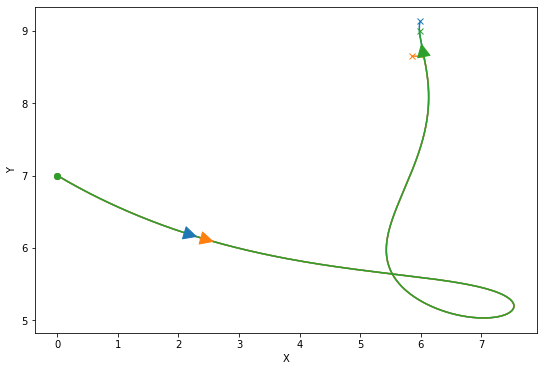

In [36]:
ss_exp = StateSpaceExperiment('quad', x_indices=[0, 2], start_x=x0, n_sims_per_start=1, t_sim=8)
ss_exp.plot(extended_dyn, results_df)

# Plot of safe sets 

Note: you can either generate your own value functions using the code above or download the `.npy` files used for generating the conceptual images in the paper by downloading the two files from this [link](https://drive.google.com/drive/folders/1196k2vBY-57w85-30rhfdUeO3w160ML6?usp=sharing)



In [37]:
conservative_case_sets_plot = False  #True
case_number = 1  # 2, 3

In [38]:
if conservative_case_sets_plot:
    offset_y = 12
    offset_phi = 12
    value_function = np.load("quad_2d/target_values_conservative.npy")
else:
    offset_y = 5
    offset_phi = 9
    value_function = np.load("quad_2d/target_values_invalid.npy")

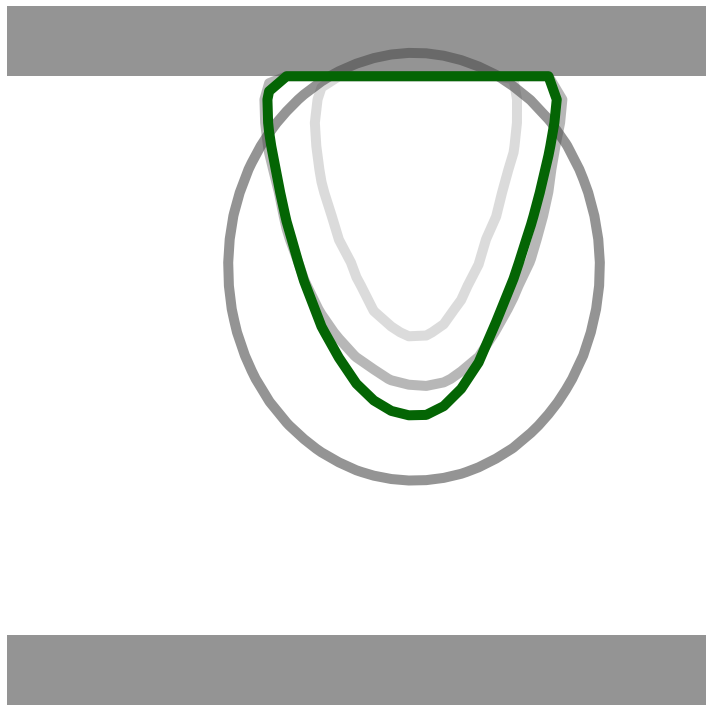

In [39]:
fig_sets = plt.figure(figsize=(10, 10))
plt.axis('off')

colors = [(0.3, 0.3, 0.3)]
colors += [(sns.color_palette("RdYlGn_r", 7)[0])]
colors += [(sns.color_palette("RdYlGn_r", 9)[6])]
colors += [(sns.color_palette("RdYlGn_r", 9)[8])]
colors += [(4 / 255, 101 / 255, 4 / 255)]
colors = np.array(colors)

plt.contourf(grid.coordinate_vectors[2], grid.coordinate_vectors[0], 
             safe_values[:, offset_y, :, offset_phi], levels=[-10, 0], 
             colors=np.array([colors[0]]), alpha=0.6)

if case_number == 1:
    cont = plt.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], 
                    value_function[0][:,offset_y,:,offset_phi], levels=[0], 
                    colors=[colors[3]], linewidths=10)
elif case_number == 2:
    cont = plt.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], 
                       value_function[0][:,offset_y,:,offset_phi], levels=[0], 
                       colors=[colors[0]], linewidths=10, alpha=0.2)
    cont = plt.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], 
                       value_function[3][:,offset_y,:,offset_phi], levels=[0], 
                       colors=[colors[2]], linewidths=10)
elif case_number == 3:
    cont = plt.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], 
                       value_function[0][:,offset_y,:,offset_phi], levels=[0], 
                       colors=[colors[0]], linewidths=10, alpha=0.6)
    cont = plt.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], 
                       value_function[3][:,offset_y,:,offset_phi], levels=[0], 
                       colors=[colors[0]], linewidths=10, alpha=0.4)
    cont = plt.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], 
                       value_function[10][:,offset_y,:,offset_phi], levels=[0], 
                       colors=[colors[0]], linewidths=10, alpha=0.2)
    cont = plt.contour(grid.coordinate_vectors[2], grid.coordinate_vectors[0], 
                       value_function[-1][:,offset_y,:,offset_phi], levels=[0], 
                       colors=[colors[-1]], linewidths=10)    
plt.tight_layout()

# Visualizations for the paper

In [40]:
exp = StateSpaceExperiment('quad', start_x=np.random.rand(6), x_indices=[0, 2], n_sims_per_start=1, 
                           t_sim=8)

In [41]:
colors = sns.color_palette("tab10")
chosen_colors = [(0.5, 0.5, 0.5)]
chosen_colors.append(colors[0])
chosen_colors.append(colors[1])
chosen_colors.append((0.1, 0.1, 0.1))
chosen_colors.append((0.7, 0.7, 0.7))

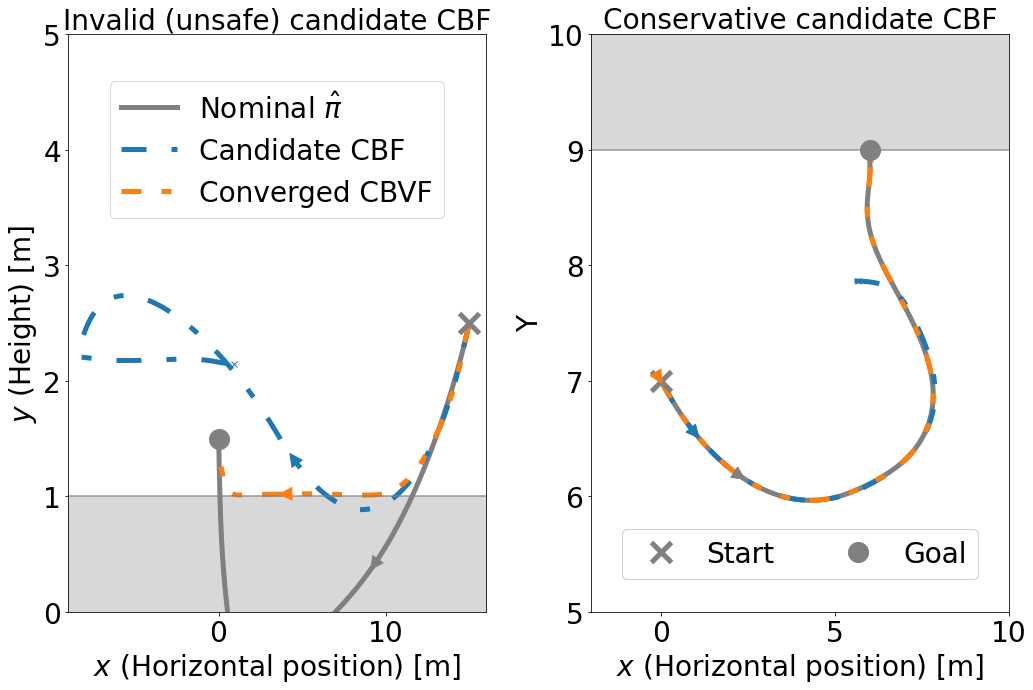

In [42]:
params = {'axes.labelsize': 28,'axes.titlesize':28, 'font.size': 28, 'legend.fontsize': 28, 'xtick.labelsize': 28, 'ytick.labelsize': 28,
'lines.linewidth': 5}
matplotlib.rcParams.update(params)
fig, axs = plt.subplots(1, 2, figsize=(15,10))
ax = axs[0]

lim = -1
exp.plot(extended_dyn, pd.read_csv('quad_2d/invalid_results.csv'), ax=ax, color=chosen_colors)
x0 = np.array([15., -3., 2.5, -2., np.pi / 4, 1])
x_goal = np.array([0., 0., 1.5, 0., 0., 0.])

ax.lines[3].set_linestyle((0, (5, 5, 2, 5)))
ax.lines[6].set_dashes([4, 4, 2, 4, 2, 4])
l1 = ax.plot(x0[0], x0[2], 'x', markersize=20, mew=5, color='grey')

l2 = ax.plot(x_goal[0], x_goal[2], 'o', markersize=20, color='grey')

miscs = [l1, l2]
new_vals_broadcast = np.repeat(np.repeat(safe_values[np.newaxis, ...], 5, axis=0)[np.newaxis, ...], 5, axis=0)
cs = ax.contourf(extended_grid.coordinate_vectors[0], extended_grid.coordinate_vectors[2], 
                 new_vals_broadcast[:, 2, :, 13, 20, 13].T, levels=[-100, 0], 
                 colors='grey', alpha=.3)
cs = ax.contour(extended_grid.coordinate_vectors[0], extended_grid.coordinate_vectors[2], 
                new_vals_broadcast[:, 2, :, 13, 20, 13].T, levels=[0], 
                colors='grey', alpha=.6, linewidths=2)

ax.set_ylim([0, 5])
ax.set_xlim([-9,16])
ax.set_xlabel('$x$ (Horizontal position) [m]')
ax.set_ylabel('$y$ (Height) [m]')


ax = axs[1]
lim = -1
exp.plot(extended_dyn, pd.read_csv("quad_2d/conservative_results.csv"), ax=ax,
                 color=chosen_colors)
ax.lines[3].set_linestyle((0, (5, 5, 2, 5)))
ax.lines[6].set_dashes([4, 4, 2, 4, 2, 4])


x0 = np.array([0., 4., 7., -2., -np.pi/4, 0.])
x_goal = np.array([6., 0., 9., 0., 0., 0.])
ax.plot()
l1 = ax.plot(x0[0], x0[2], 'x', markersize=20, mew=5, color='grey')
l2 = ax.plot(x_goal[0], x_goal[2], 'o', markersize=20, color='grey')

miscs = [l1, l2]
new_vals_broadcast = np.repeat(np.repeat(safe_values[np.newaxis, ...], 5, axis=0)[np.newaxis, ...], 5, axis=0)
cs = ax.contourf(extended_grid.coordinate_vectors[0], extended_grid.coordinate_vectors[2], 
                 new_vals_broadcast[:, 2, :, 13, 20, 13].T, levels=[-100, 0], 
                 colors='grey', alpha=.3)
ax.contour(extended_grid.coordinate_vectors[0], extended_grid.coordinate_vectors[2], 
           new_vals_broadcast[:, 2, :, 13, 20, 13].T, levels=[0], 
           colors='grey', alpha=.6, linewidths=2)

ax.set_xlim([-2, 10])
ax.set_ylim([5,10])
ax.set_xlabel('$x$ (Horizontal position) [m]')

fig.tight_layout()
axs[0].set_title('Invalid (unsafe) candidate CBF')
axs[1].set_title('Conservative candidate CBF')
leg = axs[1].legend([misc[0] for misc in miscs], ['Start', 'Goal'], 
                    ncol=2, bbox_to_anchor=[.5, 0.1], loc='center', frameon=True, handletextpad=0.6)

axs[0].legend(axs[0].lines[::3], ["Nominal $\hat \pi$", "Candidate CBF", "Converged CBVF"], 
              bbox_to_anchor=[.5, .8], ncol=1, columnspacing=1.5, 
              handletextpad=0.8, loc='center', frameon=True)
axs[1].add_artist(leg)

# plt.savefig("quad_trajectories.png", dpi=400, bbox_inches='tight')

# Animations

In [43]:
from quad_2d.animate_quad import animate_multi_planar_quad

In [44]:
produce_videos = True
conversative_case = True

In [45]:
import logging
logging.getLogger('cbf_opt').setLevel(level=logging.ERROR)

if conversative_case:
    x0 = np.array([0, 4., 7., -2., - np.pi/4, 0.])
    x_goal = np.array([6., 0., 9., 0., 0., 0.])
    xlims = [-2, 10]
    bbox1 = [.5, .35]
    bbox2 = [.5, .2]
    traj_data = pd.read_csv('quad_2d/conservative_results.csv')

else: 
    x0 = np.array([15., -3., 2.5, -2., np.pi/4, 1.])
    x_goal = np.array([0., 0., 1.5, 0., 0., 0.])
    xlims = [-5, 18]
    bbox1 = [.5, .8]
    bbox2 = [.5, .65]
    traj_data = pd.read_csv('quad_2d/invalid_results.csv')

times = traj_data.t.unique()
cbf_data = traj_data[traj_data.controller == "Analytical"]
cbvf_data = traj_data[traj_data.controller == "CBVF"]
x_vals = np.array([cbf_data.loc[cbf_data.measurement == "X", "value"]])
y_vals = np.array([cbf_data.loc[cbf_data.measurement == "Y", "value"]])
phi_vals = np.array([cbf_data.loc[cbf_data.measurement == "PHI", "value"]])
x_vals_cbvf = np.array([cbvf_data.loc[cbvf_data.measurement == "X", "value"]])
y_vals_cbvf = np.array([cbvf_data.loc[cbvf_data.measurement == "Y", "value"]])
phi_vals_cbvf = np.array([cbvf_data.loc[cbvf_data.measurement == "PHI", "value"]])

In [46]:
colors = sns.color_palette("tab10")
chosen_colors = [(0.5, 0.5, 0.5)]
chosen_colors.append(colors[0])
chosen_colors.append(colors[1])
chosen_colors.append((0.1, 0.1, 0.1))
chosen_colors.append((0.7, 0.7, 0.7))

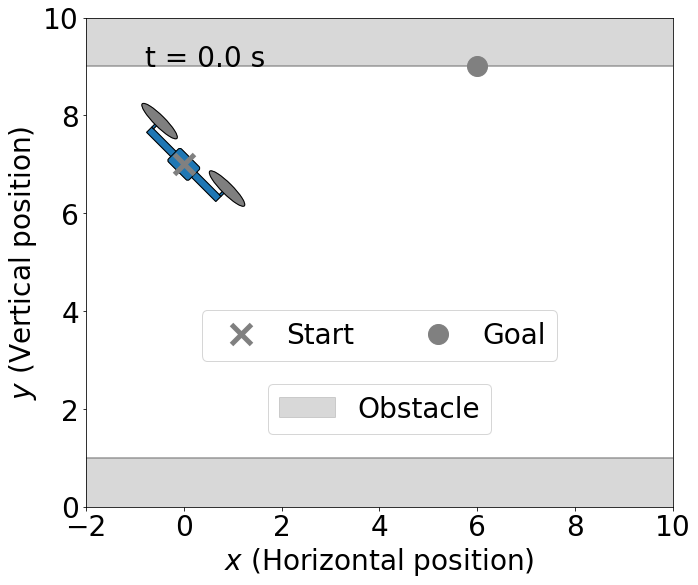

In [47]:
params = {'axes.labelsize': 28,'axes.titlesize':28, 'font.size': 28, 'legend.fontsize': 28, 
          'xtick.labelsize': 28, 'ytick.labelsize': 28, 'lines.linewidth': 5}
matplotlib.rcParams.update(params)

base_fig, ax = plt.subplots(1, 1, figsize=(16,9))
safe_values_6d = np.repeat(np.repeat(safe_values[np.newaxis, ...], 5, 
                                     axis=0)[np.newaxis, ...], 5, axis=0)
cs = ax.contourf(extended_grid.coordinate_vectors[0], extended_grid.coordinate_vectors[2], 
                 safe_values_6d[:, 2, :, 13, 20, 13].T, 
                 levels=[-100, 0], colors='grey', alpha=.3)
cs = ax.contour(extended_grid.coordinate_vectors[0], extended_grid.coordinate_vectors[2], 
                safe_values_6d[:, 2, :, 13, 20, 13].T, levels=[0], colors='grey', alpha=.6, linewidths=2)
ax.set_xlim(xlims)
ax.set_xlabel('$x$ (Horizontal position)')
ax.set_ylabel('$y$ (Vertical position)')
ax.set_ylim([0, 10])

l1 = ax.plot(x0[0], x0[2], 'x', markersize=20, mew=5, color='grey')
l2 = ax.plot(x_goal[0], x_goal[2], 'o', markersize=20, color='grey')
miscs = [l1, l2]
proxy = []
proxy += [plt.Rectangle((0,0),1,1, fc='grey', ec='grey', alpha=0.3) for pc in cs.collections]
leg = ax.legend([misc[0] for misc in miscs], ['Start', 'Goal'], ncol=2, bbox_to_anchor=bbox1, 
                loc='center', frameon=True, handletextpad=0.6)
leg2 = ax.legend(proxy, ['Obstacle'], bbox_to_anchor=bbox2, loc='center', frameon=True)
ax.add_artist(leg)

ax.set_aspect(1.0)

fig, ani = animate_multi_planar_quad(times, np.array([x_vals, x_vals_cbvf]).squeeze(), 
                                     np.array([y_vals, y_vals_cbvf]).squeeze(), 
                                     np.array([phi_vals, phi_vals_cbvf]).squeeze(),
                                     fig=base_fig, alphas=[0.5, 1], 
                                     colors=[chosen_colors[1], chosen_colors[2]])

In [48]:
# if conservative_case:
    # ani.save("conservative.mp4")
# else: 
    # ani.save("invalid.mp4")